# Setup et imports

In [1]:
#!pip install contextily
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import folium
import pandas as pd
import urllib3
from zipfile import ZipFile
import requests
import osmnx as ox
import networkx as nx

%matplotlib inline

# Utilisation de la bibliothèque OSMnx, qui utilise l'API Overpass

## Scrapping des données 
La bibliothèque donne beaucoup de possibilités de récuper les données, on peut le faire depuis une adresse, des coordonnées, la "désignation" d'un lieu. c'est cette dernière qu'on utilise car le lieu en question est suffisamment connu...

On récupère les données sous le format de la libary networkx, on peut le [convertir en GeoDataFrame](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils_graph.graph_from_gdfs) au besoin

### Réseau piéton au tour de la tour Eiffeil

In [28]:
#récupération des données piétons
tour_eiffel = "Tour Eiffel, Paris, Ile-de-France, France" #2.29394, 48.857551
g_eiffel = ox.graph_from_place(tour_eiffel,
    buffer_dist=1000,
    network_type="walk",
    retain_all=True,
    truncate_by_edge=True) #distance sur le réseau piéton, on peut mettre from address, from bbox, from a point
    # pour plus d'information : https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place
    # notamment il y a déjà un algorithme de simplification du graphe 
    #certains lieux (comme une ville) ont un polygone associée : 
# on peut donc récupérer le réseau sans indiquer de dist
# il est possible de télécharger par une autre source
#  (opendata d'une ville, insee, cartiflette, ign)
#  les polygones pour télécharger le réseau dans OSM

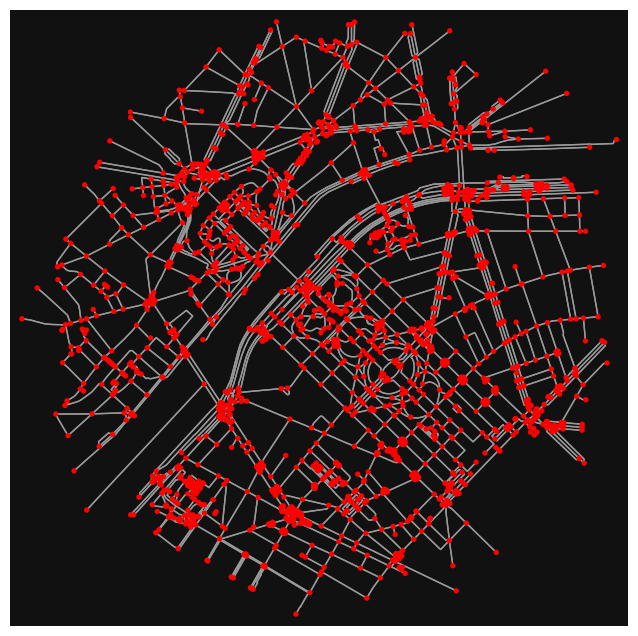

In [19]:
fig, ax = ox.plot_graph(g_eiffel, node_color="r")

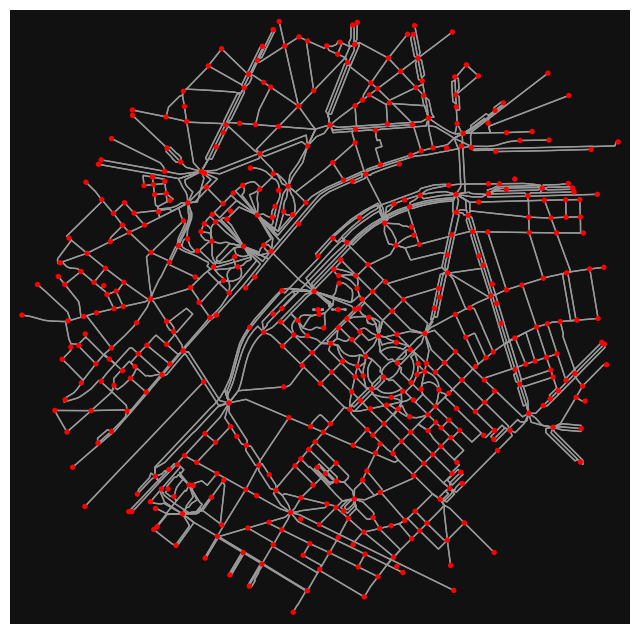

In [22]:
# regrouper des intersections qui sont globalement le même noeud
g_proj = ox.project_graph(g_eiffel)
g_eiffel2 = ox.consolidate_intersections(g_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = ox.plot_graph(g_eiffel2, node_color="r")

On peut voir sur le trocadéro qu'on est passé d'une place circulaire avec plusieurs noeuds à un noeud unique pour toute la place, représentation plus simple (et sans doute efficace) de réseau routier parisien.

In [26]:
#utilisation ou non du réseau simplifié
g_eiffel2 = ox.project_graph(g_eiffel2, to_crs="WGS-84")

g_eiffel = g_eiffel2

### Carte du réseau piéton à moins d'un kilomètre de la tour Eiffel

In [27]:
#carte interactive
# voir : https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.folium.plot_graph_folium 
map_eiffel = ox.plot_graph_folium(g_eiffel, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25,tiles="OpenStreetMap")
map_eiffel

## Données des points of interests (catégorie plus général : geometries)

### Récupération des données pour les poi de loisirs

In [139]:
#tags = {"leisure": True, "amenity":True, "shop":True} # fonctionne comme l'union et non l'intersection
tags = {"amenity":["restaurant", "cafe","bar","ice_cream","fast_food","pub","food_court","biergarten"]}
# Voir : https://wiki.openstreetmap.org/wiki/FR:%C3%89l%C3%A9ments_cartographiques 
# ce qui nous interresse est probablement le plus : 
# https://wiki.openstreetmap.org/wiki/FR:%C3%89l%C3%A9ments_cartographiques#Consommation
gdf_pois_eiffel = ox.geometries_from_place(tour_eiffel, tags, buffer_dist=1000)
#certains lieux (comme une ville) ont un polygone associée : 
# on peut donc récupérer les POI sans indiquer de dist
gdf_pois_eiffel["center"]=gdf_pois_eiffel.centroid
#chaque ligne peut être soit un polygone (par exemple pour le champ de Mars), soit un point comme un restaurant : on calcul le centre pour avoir une référence unique
gdf_pois_eiffel.head()
#On récupère directement un geodataframe cette fois ci

c:\Users\leopo\anaconda3\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.representative_point(self.data), crs=self.crs)
c:\Users\leopo\anaconda3\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.representative_point(self.data), crs=self.crs)
C:\Users\leopo\AppData\Local\Temp\ipykernel_4192\3439474999.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_pois_eiffel["center"]=gdf_pois_eiffel.centroid


amenity              brewery contact:city  \
element_type osmid                                                     
node         252958952         pub  Frog Natural Blonde        Paris   
             254494167  restaurant                  NaN          NaN   
             254497766  restaurant                  NaN          NaN   
             255060753  restaurant                  NaN          NaN   
             308684349        cafe                  NaN          NaN   

                       contact:housenumber      contact:phone  \
element_type osmid                                              
node         252958952             110 bis  +33 1 47 27 88 88   
             254494167                 NaN                NaN   
             254497766                 NaN                NaN   
             255060753                 NaN                NaN   
             308684349                 NaN                NaN   

                       contact:postcode contact:street  \
element_type osmid                                       
node         252958952            75116  Avenue Kléber   
             254494167              NaN            NaN   
             254497766              NaN            NaN   
             255060753              NaN            NaN   
             308684349              NaN            NaN   

                                                      contact:website  \
element_type osmid                                                      
node         252958952  https://www.frogpubs.com/fr/pub-XVI-paris.php   
             254494167                                            NaN   
             254497766                                            NaN   
             255060753                                            NaN   
             308684349                                            NaN   

                       microbrewery                  name  ... branch food  \
element_type osmid                                         ...               
node         252958952          yes              Frog XVI  ...    NaN  NaN   
             254494167          NaN  Le Clos des Gourmets  ...    NaN  NaN   
             254497766          NaN       Chez l'Ami Jean  ...    NaN  NaN   
             255060753          NaN            L'Astrance  ...    NaN  NaN   
             308684349          NaN        Café de l'Alma  ...    NaN  NaN   

                       nodes building name:signed building:levels  \
element_type osmid                                                  
node         252958952   NaN      NaN         NaN             NaN   
             254494167   NaN      NaN         NaN             NaN   
             254497766   NaN      NaN         NaN             NaN   
             255060753   NaN      NaN         NaN             NaN   
             308684349   NaN      NaN         NaN             NaN   

                       building:part height layer                    center  
element_type osmid                                                           
node         252958952           NaN    NaN   NaN  POINT (2.28810 48.86469)  
             254494167           NaN    NaN   NaN  POINT (2.30063 48.86003)  
             254497766           NaN    NaN   NaN  POINT (2.30596 48.86042)  
             255060753           NaN    NaN   NaN  POINT (2.28993 48.86509)  
             308684349           NaN    NaN   NaN  POINT (2.30151 48.86091)  

[5 rows x 94 columns]

### Carte interactive des restaurants et lieux de consommation à moins d'un kilomètre à pieds de la Tour Eiffel

In [140]:
"""
It is the classical folium method : you create a list with geometry point values (here gdf_pois_eiffel.center) and fir each 
coordinates, you add a marker. 
"""
tour_eiffel_latlong = [48.857551, 2.29394] #on représente en lat, long (et donc y,x)!!!
map = folium.Map(location=tour_eiffel_latlong, tiles="OpenStreetMap", zoom_start=14)

for poi in gdf_pois_eiffel.iterrows():
    # Place the markers with the popup labels and data
    x , y = (poi[1]['center'].x, poi[1]['center'].y)
    map.add_child(
        folium.Marker(
            location=[y,x],
            popup=
                 "Name: " + str(poi[1]['name']) + "<br>" #here to add name 
                #+ "Leisure: " + str(poi[1]['leisure']) + "<br>" #type 
                + "Amenity: " + str(poi[1]['amenity']) + "<br>" #type 
                + "Coordinates: " + str(y)+', '+str(x)
            ,
        
            icon=folium.Icon(color="blue"),
        )
    )


In [141]:
map

RMQ : On peut noter des différences par rapport à la carte générée à partir des données de Geofabrik quand on prend tous les leisures :
- la tour eiffel est peut (voir pas) rempli sur la carte OSMnx
- les ports ne sont pas représentés sur la carte geofabrik

A priori cela vient donc plutôt des tag et de la sélection effectuée.

### Lien réseau et POI

On donne ci-dessous un exemple de calculs entre les noeuds et les POI.

Faut il pour chaque POI calculer son noeuds le plus proche et ajouter à ces derniers une entrée dans leur propriété ?

c:\Users\leopo\anaconda3\lib\site-packages\geopandas\plotting.py:71: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
c:\Users\leopo\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


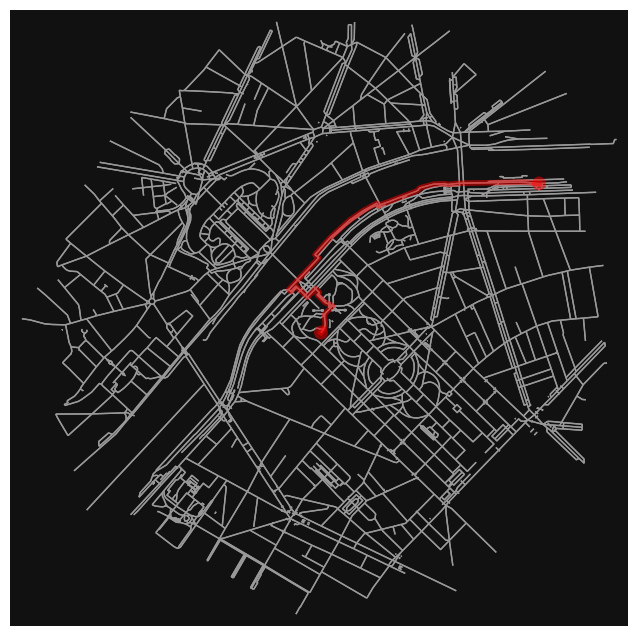

In [82]:
# pour lier les deux, on peut récuper à partir des coords d'un POI,
# le noeud (node) du graphe le plus proche. 
# Exemple : distance entre la Tour Eiffel, et le Port du Gros Caillou
tour_eiffel_xy= pd.DataFrame({'x':[tour_eiffel_latlong[1]],'y':[tour_eiffel_latlong[0]]})
gros_caillou_xy = gdf_pois_eiffel[gdf_pois_eiffel['name']=='Port du Gros Caillou']['center']
orig = ox.distance.nearest_nodes(g_eiffel,X=tour_eiffel_xy.x[0],Y = tour_eiffel_xy.y[0])
dest = ox.distance.nearest_nodes(g_eiffel,X=float(gros_caillou_xy.x),Y=float(gros_caillou_xy.y))

# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(g_eiffel, orig, dest, weight="lenght") # on peut aussi mettre travel_time
fig, ax = ox.plot_graph_route(g_eiffel, route, node_size=0)

#voir aussi : https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.shortest_path
# mais on a pas la distance par ex

Calcul de la distance entre la tour Eiffel et le port du gros caillou

In [102]:
#calcul de distance
n = len(route)-1
dist_metric = 0
for i in range(n):
    adj = g_eiffel.adj[route[i]]
    dist_metric += adj[route[i+1]][0]['length']
    #adj un dic (avec comme clé tout les noeuds adjacants, donc en autre celui de notre chemin), de dic (comme clé inconnue mais probablement les edges reliés au noeud) 
    # de dic des différentes propriétés de cette edge
dist_metric #correspond à un peu au calcul effectué à la main sur google maps

1597.1639999999998

# Utilisation des données de geofabrik

In [ ]:
# Téléchargement :
# https://download.geofabrik.de/europe/france/ile-de-france.html
data_folder = "./data/"
zipname = "Ile-de-France-Geofabrik-free"
geofabrik_idf_shp_link = "https://download.geofabrik.de/europe/france/ile-de-france-latest-free.shp.zip"
r = requests.get(geofabrik_idf_shp_link)

open(data_folder+zipname+".zip",'wb').write(r.content)

In [ ]:
# unzip des données en provenance de :
geofabrik_folder = data_folder+zipname+"/"
datafile_name = 'gis_osm_pois_a_free_1.shp'
dataextensions_unzip = ['.shp','.shx','.cpg','.dbf','.prj']
with ZipFile(data_folder+zipname+".zip") as myzip:
    for ext in dataextensions_unzip :
        myzip.extract(datafile_name[:-4]+ext, path = geofabrik_folder)

In [21]:
# ouverture des données
df_pois = gpd.read_file(geofabrik_folder+datafile_name)

# note : pois stands for points of interests

In [22]:
"""
I Only keep leisure and some shops and markets (see documentation : https://download.geofabrik.de/osm-data-in-gis-formats-free.pdf) 
"""

df_pois  = df_pois[(df_pois["code"] >= 2201) 
                   & (df_pois["code"] <= 2706)]

In [23]:

df_pois = df_pois.reset_index(drop = True) #I restart index  

In [24]:
df_pois 

,osm_id,code,fclass,name,geometry
0,4083189,2204,park,Parc de Bercy,"POLYGON ((2.37807 48.83739, 2.37812 48.83741, ..."
1,4208595,2204,park,Champ de Mars,"POLYGON ((2.29187 48.85771, 2.29230 48.85801, ..."
2,4221369,2204,park,Jardin des Plantes,"POLYGON ((2.35510 48.84374, 2.35511 48.84375, ..."
3,4263203,2204,park,Jardin du Palais Royal,"POLYGON ((2.33672 48.86417, 2.33674 48.86422, ..."
4,4410586,2204,park,None,"POLYGON ((2.20680 48.87370, 2.20770 48.87409, ..."
...,...,...,...,...,...
46023,1112119036,2421,shelter,None,"POLYGON ((2.46203 48.81455, 2.46204 48.81456, ..."
46024,1112121750,2421,shelter,None,"POLYGON ((2.41404 48.82155, 2.41410 48.82157, ..."
46025,1112127658,2421,shelter,None,"POLYGON ((2.41030 48.82361, 2.41032 48.82362, ..."
46026,1112127661,2421,shelter,None,"POLYGON ((2.40987 48.82409, 2.40989 48.82410, ..."


In [25]:
"""
I use folium to create an interative map centered in Eiffel Tower
"""


map = folium.Map(location=[48.857551, 2.29394], tiles="OpenStreetMap", zoom_start=14)
map

In [26]:
"""
I use gpd.centroid to have polygon centers (more easy to manipulate) 
"""
# geometry (active) column
df_pois = df_pois.to_crs(epsg=4326)
df_pois['center'] = df_pois.centroid
# Centroid column
df_pois["center"] = df_pois['center'].to_crs(epsg=4326)

df_pois.head()

C:\Users\leopo\AppData\Local\Temp\ipykernel_19944\2415629637.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_pois['center'] = df_pois.centroid


,osm_id,code,fclass,name,geometry,center
0,4083189,2204,park,Parc de Bercy,"POLYGON ((2.37807 48.83739, 2.37812 48.83741, ...",POINT (2.38212 48.83549)
1,4208595,2204,park,Champ de Mars,"POLYGON ((2.29187 48.85771, 2.29230 48.85801, ...",POINT (2.29792 48.85605)
2,4221369,2204,park,Jardin des Plantes,"POLYGON ((2.35510 48.84374, 2.35511 48.84375, ...",POINT (2.35926 48.84334)
3,4263203,2204,park,Jardin du Palais Royal,"POLYGON ((2.33672 48.86417, 2.33674 48.86422, ...",POINT (2.33781 48.86501)
4,4410586,2204,park,None,"POLYGON ((2.20680 48.87370, 2.20770 48.87409, ...",POINT (2.20915 48.87240)


In [27]:
"""
I filter a zone near Eiffel Tower. 
"""

gdf_pois = pd.concat([df_pois, df_pois.bounds], axis=1) #I use gpd bounds to have coordonnees in two columns and not only in Point(x,y) 

gdf_pois_eiffel = gdf_pois[(gdf_pois["minx"] >= 2.287592 ) &
        (gdf_pois["minx"] <= 2.314801) &
         (gdf_pois["miny"] >= 48.847194) &
        (gdf_pois["miny"] <= 48.866217)]

gdf_pois_eiffel = gdf_pois_eiffel.reset_index(drop = True) #reset index. 

In [28]:
"""
It is the classical folium method : you create a list with geometry point values (here gdf_pois_eiffel.center) and fir each 
coordinates, you add a marker. 
"""

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf_pois_eiffel.center] 


i = 0
for coordinates in geo_df_list:
    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            popup=
                 "Name: " + str(gdf_pois_eiffel.name[i]) + "<br>" #here to add name 
                + "type: " + str(gdf_pois_eiffel.fclass[i]) + "<br>" #type 
                + "Coordinates: " + str(geo_df_list[i])
            ,
        
            icon=folium.Icon(color="blue"),
        )
    )
    i = i + 1

In [29]:
map